In [24]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim

import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainset.train_data.shape

## 3 layer randCNN 

In [4]:
class rand_Net3(nn.Module):
    def __init__(self):
        super(rand_Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3,padding=1)
        self.conv3 = nn.Conv2d(64, 512, 3,padding=1)
        self.fc = nn.Linear(4096*2, 10)
        for p in self.conv1.parameters():
            p.requires_grad = False
        for p in self.conv2.parameters():
            p.requires_grad = False
        for p in self.conv3.parameters():
            p.requires_grad = False

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x, self.fc.weight

In [10]:
net3 = rand_Net3()
losses=[]
criterion = nn.CrossEntropyLoss() 
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # forward + backward + optimize
        outputs, fcw = net3(inputs)
            
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, net3.parameters()), lr=0.001, momentum=0.9)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        l1 = torch.abs(fcw).sum()
        #print('CRIT', criterion(outputs, labels))
        #print('L1', l1)
        
        loss = criterion(outputs, labels) #+ 0.001*l1
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            #print('L1 = %s'%l1)
    losses.append(loss.data[0])
print('Finished Training')
plt.plot(losses)

[1,  2000] loss: 2.284
[1,  4000] loss: 2.247
[1,  6000] loss: 2.212
[2,  2000] loss: 2.180
[2,  4000] loss: 2.156
[2,  6000] loss: 2.130
[3,  2000] loss: 2.108
[3,  4000] loss: 2.089
[3,  6000] loss: 2.069
[4,  2000] loss: 2.052
[4,  4000] loss: 2.040
[4,  6000] loss: 2.022
[5,  2000] loss: 2.007
[5,  4000] loss: 1.998
[5,  6000] loss: 1.989
[6,  2000] loss: 1.973
[6,  4000] loss: 1.965
[6,  6000] loss: 1.954
[7,  2000] loss: 1.949
[7,  4000] loss: 1.929
[7,  6000] loss: 1.927
[8,  2000] loss: 1.922
[8,  4000] loss: 1.911
[8,  6000] loss: 1.897
[9,  2000] loss: 1.888
[9,  4000] loss: 1.894
[9,  6000] loss: 1.884
[10,  2000] loss: 1.874
[10,  4000] loss: 1.871
[10,  6000] loss: 1.862
[11,  2000] loss: 1.857
[11,  4000] loss: 1.852
[11,  6000] loss: 1.849
[12,  2000] loss: 1.842
[12,  4000] loss: 1.840
[12,  6000] loss: 1.829
[13,  2000] loss: 1.822
[13,  4000] loss: 1.824
[13,  6000] loss: 1.820
[14,  2000] loss: 1.815
[14,  4000] loss: 1.798
[14,  6000] loss: 1.811
[15,  2000] loss: 1

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs,_ = net3(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(8):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print np.sum(class_correct)/np.sum(class_total)

Accuracy of plane : 49 %
Accuracy of   car : 51 %
Accuracy of  bird : 30 %
Accuracy of   cat : 25 %
Accuracy of  deer : 39 %
Accuracy of   dog : 41 %
Accuracy of  frog : 59 %
Accuracy of horse : 45 %
Accuracy of  ship : 62 %
Accuracy of truck : 54 %
0.4595


## 4-layer

In [20]:
class rand_Net4(nn.Module):
    def __init__(self):
        super(rand_Net4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3,padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3,padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3,padding=1)
        self.conv4 = nn.Conv2d(128, 512, 3,padding=1)

        self.fc = nn.Linear(2048, 10)
        for p in self.conv1.parameters():
            p.requires_grad = False
        for p in self.conv2.parameters():
            p.requires_grad = False
        for p in self.conv3.parameters():
            p.requires_grad = False
        for p in self.conv4.parameters():
            p.requires_grad = False
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv4(x)),kernel_size=2, stride=2)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x, self.fc.weight

[1,  2000] loss: 2.300
[1,  4000] loss: 2.295
[1,  6000] loss: 2.292
[2,  2000] loss: 2.287
[2,  4000] loss: 2.283
[2,  6000] loss: 2.280
[3,  2000] loss: 2.275
[3,  4000] loss: 2.273
[3,  6000] loss: 2.268
[4,  2000] loss: 2.264
[4,  4000] loss: 2.262
[4,  6000] loss: 2.257
[5,  2000] loss: 2.253
[5,  4000] loss: 2.250
[5,  6000] loss: 2.247
[6,  2000] loss: 2.244
[6,  4000] loss: 2.241
[6,  6000] loss: 2.237
[7,  2000] loss: 2.234
[7,  4000] loss: 2.230
[7,  6000] loss: 2.228
[8,  2000] loss: 2.225
[8,  4000] loss: 2.221
[8,  6000] loss: 2.219
[9,  2000] loss: 2.216
[9,  4000] loss: 2.212
[9,  6000] loss: 2.210
[10,  2000] loss: 2.208
[10,  4000] loss: 2.204
[10,  6000] loss: 2.201
Finished Training


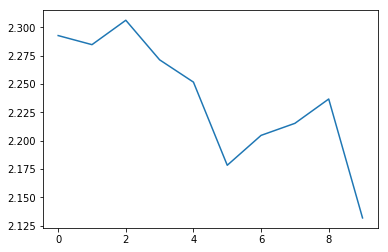

In [26]:
net4 = rand_Net4()
criterion = nn.CrossEntropyLoss() 
losses=[]
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # forward + backward + optimize
        outputs, fcw = net4(inputs)
                
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, net4.parameters()), lr=0.001, momentum=0.9)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        #l1 = torch.abs(fcw).sum()
        #print('CRIT', criterion(outputs, labels))
        #print('L1', l1)
        
        loss = criterion(outputs, labels) #+ 0.001*l1
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    losses.append(loss.data[0])
plt.plot(losses)
print('Finished Training')

In [27]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs,_ = net4(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(8):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print np.sum(class_correct)/np.sum(class_total)

Accuracy of plane : 37 %
Accuracy of   car : 29 %
Accuracy of  bird :  8 %
Accuracy of   cat :  6 %
Accuracy of  deer : 19 %
Accuracy of   dog : 14 %
Accuracy of  frog : 59 %
Accuracy of horse : 13 %
Accuracy of  ship : 37 %
Accuracy of truck : 60 %
0.2859


# try deeper network

In [33]:
#vgg11 [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
   
class rand_vgg11(nn.Module):
    def __init__(self):
        super(rand_vgg11, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,padding=1)
        
        self.conv2 = nn.Conv2d(64, 128*2, 3,padding=1)
        
        self.conv3 = nn.Conv2d(128*2, 256*2, 3,padding=1)
        self.conv4 = nn.Conv2d(256*2, 256*2, 3,padding=1)
                
        self.conv5 = nn.Conv2d(256*2, 512*4, 3,padding=1)
        self.conv6 = nn.Conv2d(512*4, 512*4, 3,padding=1)
        
        self.conv7 = nn.Conv2d(512*4, 512*4, 3,padding=1)
        self.conv8 = nn.Conv2d(512*4, 512*4, 3,padding=1)

        self.fc = nn.Linear(512*4, 10)
        for p in self.conv1.parameters():
            p.requires_grad = False
        for p in self.conv2.parameters():
            p.requires_grad = False
        for p in self.conv3.parameters():
            p.requires_grad = False
        for p in self.conv4.parameters():
            p.requires_grad = False
        for p in self.conv5.parameters():
            p.requires_grad = False
        for p in self.conv6.parameters():
            p.requires_grad = False
        for p in self.conv7.parameters():
            p.requires_grad = False
        for p in self.conv8.parameters():
            p.requires_grad = False
            
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2, stride=2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv4(x)),kernel_size=2, stride=2)
        
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(F.relu(self.conv6(x)),kernel_size=2, stride=2)
        
        x = F.relu(self.conv7(x))
        x = F.max_pool2d(F.relu(self.conv8(x)),kernel_size=2, stride=2)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x, self.fc.weight

In [ ]:
netvgg11 = rand_vgg11()
criterion = nn.CrossEntropyLoss() 
losses=[]
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # forward + backward + optimize
        outputs, fcw = netvgg11(inputs)
                
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, netvgg11.parameters()), lr=0.001, momentum=0.9)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        #l1 = torch.abs(fcw).sum()
        #print('CRIT', criterion(outputs, labels))
        #print('L1', l1)
        
        loss = criterion(outputs, labels) #+ 0.001*l1
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    losses.append(loss.data[0])
plt.plot(losses)
print('Finished Training')

In [32]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs,_ = netvgg11(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(8):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print np.sum(class_correct)/np.sum(class_total)

Accuracy of plane :  0 %
Accuracy of   car :  0 %
Accuracy of  bird :  0 %
Accuracy of   cat :  0 %
Accuracy of  deer : 100 %
Accuracy of   dog :  0 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  0 %
Accuracy of truck :  0 %
0.1


## Compare to pixel by pixel Lasso classification

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=7000,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=500,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [19]:
from sklearn import linear_model,metrics,preprocessing
from sklearn.ensemble import RandomForestClassifier

print('compute purely on pixels')
for ty,data in enumerate(trainloader):
    images, labels = data
    for alpha in [1]:#np.logspace(0,3,10):
        print alpha
        reg = linear_model.LogisticRegression(penalty='l1',solver ='saga',C = alpha,n_jobs=6,max_iter=3)
        rf = RandomForestClassifier(n_estimators = 300,n_jobs=6)
        reg.fit(images[:,:,:,:].numpy().reshape(7000,-1) , labels) 
        rf.fit(images[:,:,:,:].numpy().reshape(7000,-1) , labels) 
    for mod in [reg,rf]:
        print ("-----")
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        for a,data in enumerate(testloader):
            imagesp, labelsp = data
            predicted = mod.predict(imagesp[:,:,:,:].numpy().reshape(500,-1))
            c = (predicted == labelsp).squeeze()
            for i in range(500):
                label = labelsp[i]
                class_correct[label] += c[i]
                class_total[label] += 1
            if a>=4:
                break 
        for i in range(10):
            print('Accuracy of %5s : %2d %%' % (
                classes[i], 100 * class_correct[i] / class_total[i]))
        print np.sum(class_correct)/np.sum(class_total)
    break



compute purely on pixels
1
-----
Accuracy of plane : 43 %
Accuracy of   car : 43 %
Accuracy of  bird : 26 %
Accuracy of   cat : 17 %
Accuracy of  deer : 28 %
Accuracy of   dog : 27 %
Accuracy of  frog : 48 %
Accuracy of horse : 48 %
Accuracy of  ship : 53 %
Accuracy of truck : 41 %
0.3804
-----
Accuracy of plane : 46 %
Accuracy of   car : 46 %
Accuracy of  bird : 33 %
Accuracy of   cat : 21 %
Accuracy of  deer : 32 %
Accuracy of   dog : 36 %
Accuracy of  frog : 51 %
Accuracy of horse : 45 %
Accuracy of  ship : 66 %
Accuracy of truck : 51 %
0.4368
